## Calculate irradiance

In [32]:
irrad_expr = mms.sphere_integral(
    sol_expr,
    angle=angle
)

irrad_sym = mms.symify(irrad_expr, *space, **param_vals)
irrad_func_N = kelp_compute.sym_to_num(irrad_sym, *space)

## Numerical Solution

In [ ]:
# Grid options
ns = 16
nz = 16
na = 10
nomega = na*(na-2) + 2

# Domain size
rope_spacing = 1
zmax = 1

# Solver options
lis_opts = "-i gmres -restart 100 -tol 1e-3"
num_scatters = 1

# Numerical function for source expansion
source_expansion_N = gen_series_N(source_expr, num_scatters, **param_vals)

# Calculate leading order solution
_, noscat_results = kelp_compute.solve_rte_with_callbacks_full(
    ns, nz, na,
    rope_spacing, zmax,
    b, abs_sym, source_sym, source_expansion_N, bc_sym, vsf_sym,
    num_scatters=0, fd_flag=False, lis_opts=lis_opts
)

# Calculate asymptotic solution
_, asymptotic_results = kelp_compute.solve_rte_with_callbacks_full(
    ns, nz, na,
    rope_spacing, zmax,
    b, abs_sym, source_sym, source_expansion_N, bc_sym, vsf_sym,
    num_scatters=num_scatters, fd_flag=False, lis_opts=lis_opts
)

# Calculate finite difference solution
_, fd_results = kelp_compute.solve_rte_with_callbacks_full(
    ns, nz, na,
    rope_spacing, zmax,
    b, abs_sym, source_sym, source_expansion_N, bc_sym, vsf_sym,
    num_scatters=0, fd_flag=True, lis_opts=lis_opts
)

# Extract numerical solutions
noscat_sol = noscat_results['rad']
asymptotic_sol = asymptotic_results['rad']
fd_sol = fd_results['rad']

# Evaluate true solution on same grid
x, y, z, theta, phi = gen_grid(ns, nz, na, rope_spacing, zmax)
true_sol = sol_func_N(x, y, z, theta, phi)
true_irrad = irrad_func_N(x, y, z)[:,:,:,0]

## Symbolic Solution (no scattering)

In [ ]:
one_angle_dict = {
    'theta': th,
    'phi': ph
}
one_angle_tuple = (th, ph)

In [ ]:
# Declare variables
s, s_p, s_pp = sp.var('s, s_p, s_{pp}')
x0, y0 = sp.var('x_0, y_0')
vec_x0 = sp.Matrix([x0, y0, 0])

In [ ]:
do_symbolic = True
num_sym_scat = 1
if do_symbolic:
    # Calculate absorption and source
    # along ray path
    a_tilde = abs_sym(
        *sp.simplify(
            subs_dict(
                vec_l0(vec_x0, vec_om, s_pp, zmax),
                one_angle_dict
            )
        )
    )
    sigma_tilde = source_sym(
        *sp.simplify(
            subs_dict(
                vec_l0(vec_x0, vec_om, s_p, zmax),
                one_angle_dict
            )
        ), 
        *one_angle_tuple
    )

    # Integrate light from distributed source
    u0_source_expr = sp.integrate(
        sigma_tilde * sp.exp(
            -sp.integrate(
                a_tilde,
                (s_pp, s_p, s)
            )
        ),
        (s_p, 0, s)
    )

    # Integrate light from boundary condition
    u0_bc_expr = (
        bc_sym(*angle) * sp.exp(
            -sp.integrate(
                a_tilde,
                (s_pp, 0, s)
            )
        )
    )

    # Superpose source and bc solutions
    u0_s_expr = u0_source_expr + u0_bc_expr

    # Convert to funcion of x, y, z
    u0_func = sp.lambdify(
        ('s', 'x_0', 'y_0'),
        u0_s_expr,
        modules=("sympy",)
    )
    L_symbolic_expr = u0_func(
        sp.Symbol('z')*sp.sec(ph),
        sp.Symbol('x') - sp.Symbol('z')*sp.tan(ph)*sp.cos(th),
        sp.Symbol('y') - sp.Symbol('z')*sp.tan(ph)*sp.sin(th),
    )

    # Convert to numerical function
    L_symbolic_N = sp.lambdify(
        space,
        L_symbolic_expr, 
    )

    # Evaluate on discrete grid
    symbolic_sol = L_symbolic_N(x, y, z)

## Plot

## 1D Slices

In [ ]:
plot_inds = np.zeros_like(true_sol, dtype=bool)
plot_inds[0,0,:,p] = True

# Source & abs
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(z[plot_inds], abs_func_N(x,y,z)[plot_inds], 'C0o-', label='abs')
plt.plot(z[plot_inds], source_func_N(x,y,z,theta,phi)[plot_inds], 'C1o-', label='source')
plt.xlabel('z')
plt.legend()

# Solution
plt.subplot(2,2,2)
plt.plot(z[plot_inds], true_sol[plot_inds], 'C2o-', label='true')
plt.plot(z[plot_inds], noscat_sol[plot_inds], 'C3o-', label='noscat')
plt.plot(z[plot_inds], asymptotic_sol[plot_inds], 'C4o-', label='asym')
plt.plot(z[plot_inds], fd_sol[plot_inds], 'C5o-', label='fd')
plt.plot(z[plot_inds], symbolic_sol[plot_inds], 'C6o-', label='symbolic')
plt.xlabel('z')
plt.ylabel('sol')
plt.legend()

# Error
plt.subplot(2,2,3)
plt.plot(z[plot_inds], -true_sol[plot_inds]+true_sol[plot_inds], 'C2o-', label='true')
plt.plot(z[plot_inds], -true_sol[plot_inds]+noscat_sol[plot_inds], 'C3o-', label='noscat')
plt.plot(z[plot_inds], -true_sol[plot_inds]+asymptotic_sol[plot_inds], 'C4o-', label='asym')
plt.plot(z[plot_inds], -true_sol[plot_inds]+fd_sol[plot_inds], 'C5o-', label='fd')
plt.plot(z[plot_inds], -true_sol[plot_inds]+symbolic_sol[plot_inds], 'C6o-', label='symbolic')
plt.xlabel('z')
plt.ylabel('sol - true')
plt.legend()

# Log Error
plt.subplot(2,2,4)
plt.plot(z[plot_inds], np.log(np.abs(-true_sol[plot_inds]+noscat_sol[plot_inds])), 'C3o-', label='noscat')
plt.plot(z[plot_inds], np.log(np.abs(-true_sol[plot_inds]+asymptotic_sol[plot_inds])), 'C4o-', label='asym')
plt.plot(z[plot_inds], np.log(np.abs(-true_sol[plot_inds]+fd_sol[plot_inds])), 'C5o-', label='fd')
plt.plot(z[plot_inds], np.log(np.abs(-true_sol[plot_inds]+symbolic_sol[plot_inds])), 'C6o-', label='symbolic')
plt.xlabel('z')
plt.ylabel('sol - true')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
np.abs(true_sol - symbolic_sol).max()

## 2D Slices

In [ ]:
plt.figure()
plt.contourf(x[:,0,:,0], z[:,0,:,0], true_sol[:,0,:,0])
plt.colorbar()
plt.title('true')
plt.xlabel('x')
plt.ylabel('z')

plt.figure()
plt.contourf(x[:,0,:,0], z[:,0,:,0], fd_sol[:,0,:,0])
plt.colorbar()
plt.title('fd')
plt.xlabel('x')
plt.ylabel('z')

plt.figure()
plt.contourf(x[:,0,:,0], z[:,0,:,0], noscat_sol[:,0,:,0])
plt.colorbar()
plt.title('noscat')
plt.xlabel('x')
plt.ylabel('z')

plt.figure()
plt.contourf(x[:,0,:,0], z[:,0,:,0], asymptotic_sol[:,0,:,0])
plt.colorbar()
plt.title('asymptotic')
plt.xlabel('x')
plt.ylabel('z')
plt.show()

## Volume Plots

### True

In [ ]:
discrete_plot.volshow_zoom_correct_scale(x[:,0,0,0], y[0,:,0,0], z[0,0,:,0], true_irrad)

### FD

In [ ]:
discrete_plot.volshow_zoom_correct_scale(x[:,0,0,0], y[0,:,0,0], z[0,0,:,0], fd_results['irrad'])

### Noscat

In [ ]:
discrete_plot.volshow_zoom_correct_scale(x[:,0,0,0], y[0,:,0,0], z[0,0,:,0], noscat_results['irrad'])

### Asymptotics

In [ ]:
discrete_plot.volshow_zoom_correct_scale(x[:,0,0,0], y[0,:,0,0], z[0,0,:,0], asymptotic_results['irrad'])

### Calculating convergence rate the dumb way

ns
err 4: 0.013038305159836724
err 5: 0.007608520629303119
err 6: 0.0050298034514082495
err 7: 0.003591425934813914
err 8: 0.002702761153780061
err 9: 0.0021137744357448813
err 10: 0.0017029819640249804
err 11: 0.0014052097555597573
err 12: 0.0011827887566821314
err 13: 0.0010126442183582551
err 14: 0.0008799645940137022
err 15: 0.0007748681061444424
err 16: 0.000690543572543439


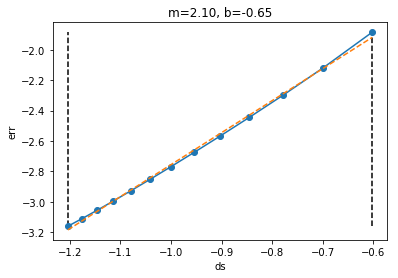

nz
err 4: 0.0012032135750432442
err 5: 0.0009340021735807432
err 6: 0.0007891209306822283
err 7: 0.0007255204440690623
err 8: 0.000690543572543439


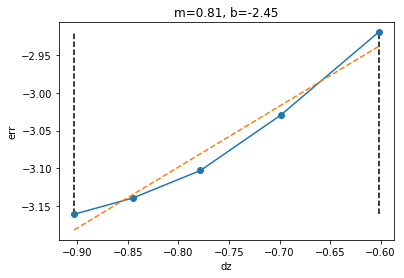

ntheta
err 4: 0.0007550665228704386
err 6: 0.0007228774850481203
err 8: 0.000690543572543439


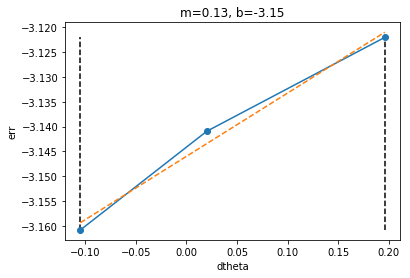

nphi
err 4: 0.0006536445915030987
err 6: 0.0007111184128409173
err 8: 0.000690543572543439


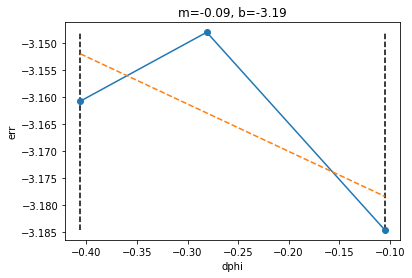

In [190]:
# Regular L2 norm
norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
# Make norm independent of vector size
norm = lambda x: np.sqrt(np.sum(x**2)/np.size(x))
# Arithmetic mean
# norm = lambda x: np.sum(np.abs(x))/np.size(x)

# ns
print("ns")
err_dict = {}
for ns in ns_list:
    results_list = kelp_analyze.query_results(
        conn, study_name, 
        ns=ns, nz=nz_max, ntheta=ntheta_max, nphi=nphi_max
    )
    
    rad = results_list[0]['rad'][:]
    true_rad = results_list[0]['true_rad'][:]
    
    err = norm(rad - true_rad)
    print("err {}: {}".format(ns, err))
    err_dict[ns] = err

res_arr = rope_spacing / np.array(ns_list)
err_arr = np.array([err_dict[ns] for ns in ns_list])

plot_lin_fit(
    np.log10(res_arr), np.log10(err_arr), 
    min(np.log10(res_arr)), max(np.log10(res_arr)), 
    xlabel='ds', ylabel='err'
)

# nz
print("nz")
err_dict = {}
for nz in nz_list:
    results_list = kelp_analyze.query_results(
        conn, study_name, 
        ns=ns_max, nz=nz, ntheta=ntheta_max, nphi=nphi_max
    )
    
    rad = results_list[0]['rad'][:]
    true_rad = results_list[0]['true_rad'][:]
    
    err = norm(rad - true_rad)
    print("err {}: {}".format(nz, err))
    err_dict[nz] = err

res_arr = zmax / np.array(nz_list)
err_arr = np.array([err_dict[nz] for nz in nz_list])

plot_lin_fit(
    np.log10(res_arr), np.log10(err_arr), 
    min(np.log10(res_arr)), max(np.log10(res_arr)), 
    xlabel='dz', ylabel='err'
)

# ntheta
print("ntheta")
err_dict = {}
for ntheta in ntheta_list:
    results_list = kelp_analyze.query_results(
        conn, study_name, 
        ns=ns_max, nz=nz_max, ntheta=ntheta, nphi=nphi_max
    )
    
    rad = results_list[0]['rad'][:]
    true_rad = results_list[0]['true_rad'][:]
    
    err = norm(rad - true_rad)
    print("err {}: {}".format(ntheta, err))
    err_dict[ntheta] = err

res_arr = 2*np.pi / np.array(ntheta_list)
err_arr = np.array([err_dict[ntheta] for ntheta in ntheta_list])

plot_lin_fit(
    np.log10(res_arr), np.log10(err_arr), 
    min(np.log10(res_arr)), max(np.log10(res_arr)), 
    xlabel='dtheta', ylabel='err'
)

# nphi
print("nphi")
err_dict = {}
for nphi in nphi_list:
    results_list = kelp_analyze.query_results(
        conn, study_name, 
        ns=ns_max, nz=nz_max, ntheta=ntheta_max, nphi=nphi
    )
    
    rad = results_list[0]['rad'][:]
    true_rad = results_list[0]['true_rad'][:]
    
    err = norm(rad - true_rad)
    print("err {}: {}".format(nphi, err))
    err_dict[nphi] = err

res_arr = np.pi / np.array(nphi_list)
err_arr = np.array([err_dict[nphi] for nphi in nphi_list])

plot_lin_fit(
    np.log10(res_arr), np.log10(err_arr), 
    min(np.log10(res_arr)), max(np.log10(res_arr)), 
    xlabel='dphi', ylabel='err'
)

### Test values

In [ ]:
# Change nz

In [ ]:
ns = 12
nz = 12
ntheta = 10
nphi = 10
grid = mms.gen_grid(ns, nz, ntheta, nphi, rope_spacing, zmax)
x, y, z, theta, phi = grid
x1 = x[:,0,0,0]
y1 = y[0,:,0,0]
z1 = z[0,0,:,0]
results_list = kelp_analyze.query_results(
    conn, study_name, 
    ns=ns, nz=nz, ntheta=ntheta, nphi=nphi
)
large_approx_rad = results_list[0]['rad'][:]
large_approx_irrad = results_list[0]['irrad'][:]
large_true_rad = results_list[0]['true_rad'][:]
large_true_irrad = np.asfortranarray(np.zeros_like(large_approx_irrad))
lu.calculate_irradiance(large_true_rad, large_true_irrad, ntheta, nphi)

ns = 12
nz = 4
ntheta = 10
nphi = 10
grid = mms.gen_grid(ns, nz, ntheta, nphi, rope_spacing, zmax)
x, y, z, theta, phi = grid
x2 = x[:,0,0,0]
y2 = y[0,:,0,0]
z2 = z[0,0,:,0]
results_list = kelp_analyze.query_results(
    conn, study_name, 
    ns=ns, nz=nz, ntheta=ntheta, nphi=nphi
)
small_approx_rad = results_list[0]['rad'][:]
small_approx_irrad = results_list[0]['irrad'][:]
small_true_rad = results_list[0]['true_rad'][:]
small_true_irrad = np.asfortranarray(np.zeros_like(small_approx_irrad))
lu.calculate_irradiance(small_true_rad, small_true_irrad, ntheta, nphi)

large_inds = np.zeros_like(large_approx_rad, dtype=bool)
large_inds[3,1,:,0] = True

small_inds = np.zeros_like(small_approx_rad, dtype=bool)
small_inds[3,1,:,0] = True

plt.plot(z1, large_approx_rad[large_inds], 'o-', label='large_approx')
plt.plot(z1, large_true_rad[large_inds], 'o-', label='large_true')

plt.plot(z2, small_approx_rad[small_inds], 'o-', label='small_approx')
plt.plot(z2, small_true_rad[small_inds], 'o-', label='small_true')
plt.legend()

                                     
#discrete_plot.volshow_zoom_correct_scale(x1, y1, z1, large_irrad, zoom_factor=3),
#discrete_plot.volshow_zoom_correct_scale(x2, y2, z2, small_irrad, zoom_factor=3)

In [ ]:
np.size(large_approx_rad)

In [ ]:
np.size(small_approx_rad)

In [ ]:
norm((small_approx_rad - small_true_rad))

In [ ]:
norm((large_approx_rad - large_true_rad))

In [ ]:
small_approx_rad - small_true_rad

In [ ]:
# Check constraints for numerical solution
# - No upwelling light from below
print("bottom")
print(np.mean(large_approx_rad[:,:,-1,int(nomega/2):]))
# - Periodic in x, y
print("x") 
print(np.mean(large_approx_rad[0,:,:,:]-large_approx_rad[-1,:,:,:]))
print("y") 
print(np.mean(large_approx_rad[:,0,:,:]-large_approx_rad[0,1,:,:]))
# - BC satisfied from above
print("bc above")
print(np.mean(large_approx_rad[:,:,0,:int(nomega/2+1)] - bc_func_N(theta[:,:,0,:int(nomega/2+1)], phi[:,:,0,:int(nomega/2+1)])))

In [ ]:
discrete_plot.volshow_zoom_correct_scale(x1, y1, z1, large_approx_irrad)
discrete_plot.volshow_zoom_correct_scale(x1, y1, z1, large_true_irrad)

In [ ]:
print("hi")

In [ ]:
1/0

# Single-run

### Compute

In [ ]:
# Grid options
ns = 16
nz = 16
na = 10
nomega = na*(na-2) + 2

# Domain size
rope_spacing = 1
zmax = 1

# Solver options
lis_opts = "-i gmres -restart 100 -tol 1e-3"

# Set num_scatters
num_scatters_list = range(5)
max_num_scatters = max(num_scatters_list)

# Norm for error calculations
norm = lambda arr: np.linalg.norm(np.ravel(arr), ord=2)/np.size(arr)

# Numerical function for solution expansion
sol_expansion_N = mms.gen_series_N(sol_expr, max_num_scatters, **param_vals)

asymptotic_sol_dict = {}
sol_expansion_dict = {}
asymptotic_err_dict = {}
sol_expansion_err_dict = {}

for num_scatters in num_scatters_list:
    print("n={}".format(num_scatters))
    # Calculate asymptotic solution
    _, asymptotic_results = kelp_compute.solve_rte_with_callbacks_full(
        ns, nz, na,
        rope_spacing, zmax,
        b, abs_expr, source_expr, source_expansion_N, bc_expr, vsf_expr,
        param_dict, num_scatters=num_scatters, fd_flag=False, lis_opts=lis_opts
    )

    # Extract numerical solutions
    asymptotic_sol = asymptotic_results['rad']
    
    # Store results
    asymptotic_sol_dict[num_scatters] = asymptotic_sol
    
    # Evaluate true solution
    x, y, z, theta, phi = mms.gen_grid(ns, nz, na, rope_spacing, zmax)
    true_sol = sol_func_N(x, y, z, theta, phi)
    
    # Evaluate series expansion
    sol_expansion = np.zeros_like(asymptotic_sol)
    for n in range(num_scatters+1):
        sol_expansion += b**n * sol_expansion_N(x, y, z, theta, phi, n) 
    sol_expansion_dict[num_scatters] = sol_expansion
    
    # Calculate errors
    asymptotic_err = norm(asymptotic_sol-true_sol)
    asymptotic_err_dict[num_scatters] = asymptotic_err
    
    sol_expansion_err = norm(sol_expansion - true_sol)
    sol_expansion_err_dict[num_scatters] = sol_expansion_err

# Evaluate true solution on same grid
true_sol = sol_func_N(x, y, z, theta, phi)

In [ ]:
# Calculate finite difference solution
_, fd_results = kelp_compute.solve_rte_with_callbacks_full(
    ns, nz, na,
    rope_spacing, zmax,
    b, abs_sym, source_sym, source_expansion_N, bc_sym, vsf_sym,
    num_scatters=0, fd_flag=True, lis_opts=lis_opts
)

fd_sol = fd_results['rad']

fd_err = norm(fd_sol-true_sol)

### Plot

In [ ]:
# Pick one angle to evaluate symbolically and plot
l = 0
m = int(np.floor(na/4))

p = mms.p_hat(l, m, na)
th = theta[0,0,0,p]
ph = phi[0,0,0,p]

In [ ]:
plot_inds = np.zeros_like(true_sol, dtype=bool)
plot_inds[0,0,:,p] = True

plt.figure(figsize=(12,8))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,3)
ax4 = plt.subplot(2,2,4)

# Plot true solution
ax1.plot(z[plot_inds], true_sol[plot_inds], 'C0o-', label='true')

# Plot FD solution
ax1.plot(
    z[plot_inds],
    fd_sol[plot_inds], 
    'C1o-',
    label='FD'
)

# Plot FD error
ax2.plot(
    z[plot_inds], 
    -true_sol[plot_inds]+fd_sol[plot_inds], 
    'C1o-',
    label='FD'
)

ax3.plot(
    z[plot_inds], 
    np.abs(-true_sol[plot_inds]+fd_sol[plot_inds]), 
    'C1o-',
    label='FD'
)

for num_scatters in num_scatters_list:
    ax1.plot(
        z[plot_inds], 
        sol_expansion_dict[num_scatters][plot_inds], 
        'C{}o-'.format(num_scatters+2), 
        label='n={}'.format(num_scatters)
    )
    ax1.plot(
        z[plot_inds], 
        asymptotic_sol_dict[num_scatters][plot_inds], 
        'C{}o--'.format(num_scatters+2)
    )
    
    # Plot true expansion error
    ax2.plot(
        z[plot_inds], 
        -true_sol[plot_inds]+sol_expansion_dict[num_scatters][plot_inds], 
        'C{}o-'.format(num_scatters+2), 
        label='n={}'.format(num_scatters)
    )
    ax3.plot(
        z[plot_inds], 
        np.abs(-true_sol[plot_inds]+sol_expansion_dict[num_scatters][plot_inds]), 
        'C{}o-'.format(num_scatters+2), 
        label='n={}'.format(num_scatters)
    )
    
    # Plot numerical asymptotics error
    ax2.plot(
        z[plot_inds], 
        -true_sol[plot_inds]+asymptotic_sol_dict[num_scatters][plot_inds], 
        'C{}o--'.format(num_scatters+2)
    )
    ax3.plot(
        z[plot_inds], 
        np.abs(-true_sol[plot_inds]+asymptotic_sol_dict[num_scatters][plot_inds]), 
        'C{}o--'.format(num_scatters+2)
    )
    
    
ax1.set_xlabel('z')
ax1.set_ylabel('rad')
ax1.legend()

ax2.set_xlabel('z')
ax2.set_ylabel('stripe diff')
ax2.set_yscale('linear')
ax2.legend()

ax3.set_xlabel('z')
ax3.set_ylabel('stripe err')
ax3.set_yscale('log')
ax3.legend()

# FD Error
ax4.hlines(fd_err, xmin=0, xmax=max_num_scatters, label='FD')

# Asymptotics error
ax4.plot(
    num_scatters_list, 
    [asymptotic_err_dict[n] for n in num_scatters_list],
    'o-',
    label='asym. err.'
)
# Expansion error
ax4.plot(
    num_scatters_list, 
    [sol_expansion_err_dict[n] for n in num_scatters_list],
    'o-',
    label='series err.'
)
ax4.set_xlabel('n')
ax4.set_ylabel('avg. tot. err.')
ax4.set_yscale('linear')
ax4.legend()

## Compare to n=0

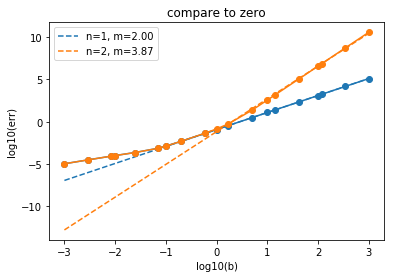

In [31]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

b_list, num_scatters_list = kelp_analyze.get_unique_vals(conn, study_name, ['b', 'num_scatters'])

zero_rad = []
for num_scatters in num_scatters_list:
    err_list = []
    for i, b in enumerate(b_list):
        results_list = kelp_analyze.query_results(
            conn, study_name,
            b=b,
            num_scatters=num_scatters,
        )

        rad = results_list[0]['rad'][:]

        if num_scatters == 0:
            zero_rad.append(rad)
        else:
            err = norm(rad - zero_rad[i])
            err_list.append(err)

    if num_scatters > 0:
        b_arr = np.array(b_list)
        err_arr = np.array(err_list)
    
        conv.plot_lin_fit(
            np.log10(b_arr), np.log10(err_arr), 
            0*min(np.log(b_arr)), max(np.log(b_arr)), 
            xlabel='log10(b)', ylabel='log10(err)',
            label='n=%d, m={m:.2f}' % num_scatters
        )

    plt.title('compare to zero')

plt.legend()